## 0.0 Importing Necessary Linraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor

## 1.0 Taking a Look at the Dataset

This dataset consists of 13 columns and around 190000 rows

In [106]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")
pd.set_option('display.max_columns', 1000)
train_dataset.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [107]:
#Checking for missing Values

print(train_dataset.isnull().sum())
print(test_dataset.isnull().sum())

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


<Axes: >

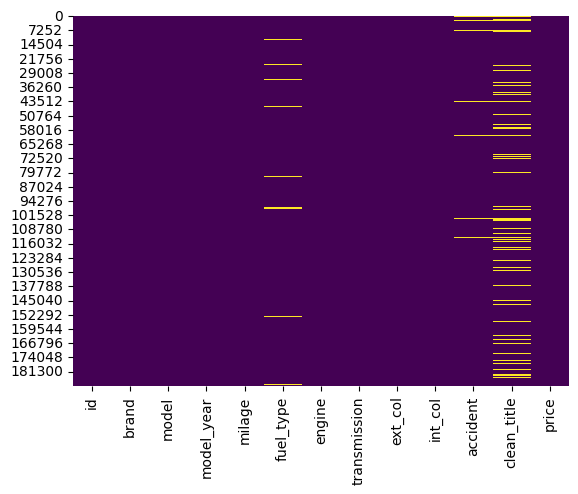

In [108]:
# Sns plot of missing values
sns.heatmap(train_dataset.isnull(), cbar=False, cmap="viridis")

Now we must try to replace these Nan's with actual Values

## 2.0 Getting rid of unnecessary columns and normalizing the dataset
* Dropping the `id` column
* Replacing `Nan` Values
* Normalizing the dataset
* Normalizing the target dataset for better results

In [109]:
# Dropping the "id" column
train_dataset.drop("id",axis=1, inplace=True)

In [110]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Using LabelEncoder() for categorical columns
le = LabelEncoder()
for col in ["brand", "model", "fuel_type", "transmission", "ext_col", "int_col"]:
    train_dataset[col] = le.fit_transform(train_dataset[col].astype(str))

# Using StandardScaler for numeric columns
scaler = StandardScaler()
numerical_cols = ["milage", "model_year"]
train_dataset[numerical_cols] = scaler.fit_transform(train_dataset[numerical_cols])
train_dataset["accident"] = train_dataset["accident"].map({
    'None Reported':0,
    'At least 1 accident or damage reported': 1
}).fillna(0)

# Getting ["HorsePower", "Liters", "Cylinders"] from the `engine` column and creating new data
import re
def extract_engine_features(engine_str):
    hp = re.search(r'(\d+\.?\d*)HP', engine_str)
    liters = re.search(r'(\d+\.?\d*)L', engine_str)
    cylinders = re.search(r'(\d+) Cylinder', engine_str)
    return {
        'horsepower': float(hp.group(1)) if hp else 0,
        'engine_size': float(liters.group(1)) if liters else 0,
        'cylinders': int(cylinders.group(1)) if cylinders else 0,
    }

engine_features = train_dataset['engine'].apply(extract_engine_features)
engine_df = pd.DataFrame(engine_features.tolist())
train_dataset = pd.concat([train_dataset, engine_df], axis=1)
train_dataset.drop(columns=['engine'], inplace=True)

# The Nan values left are in the `clean_title` column, changing them to [0, 1]
train_dataset["clean_title"] = train_dataset["clean_title"].map({
    "Yes":1,
    "No":0
}).fillna(0)

# Dropping the unnecessary column "model", this gave me 4% better results
train_dataset.drop(columns=["model"], inplace=True)
train_dataset

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,cylinders
0,31,-1.559808,2.957842,2,38,312,71,0.0,1.0,4200,172.0,1.6,4
1,28,-2.443052,1.557184,2,38,263,10,1.0,1.0,4999,252.0,3.9,8
2,9,-2.443052,1.426276,1,38,38,71,0.0,1.0,13900,320.0,5.3,8
3,16,0.206679,-0.927854,2,49,29,14,0.0,1.0,45000,420.0,5.0,8
4,36,0.913274,-1.171076,2,23,29,10,0.0,1.0,97500,208.0,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8,0.206679,-0.335461,2,49,304,10,0.0,1.0,27500,420.0,6.2,8
188529,36,0.383328,-0.745116,2,31,304,14,1.0,1.0,30000,385.0,3.0,6
188530,36,0.913274,-1.045328,2,23,304,14,0.0,1.0,86900,469.0,4.0,8
188531,3,1.089923,-1.040409,2,1,82,14,0.0,0.0,84900,0.0,3.0,0


<Axes: >

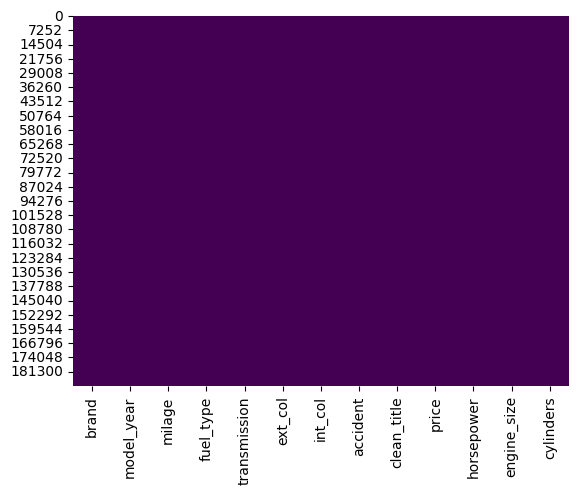

In [112]:
# Sns plot of missing values
sns.heatmap(train_dataset.isnull(), cbar=False, cmap="viridis")

In [113]:
# Checking to see is there any missing values left
print(train_dataset.isnull().sum())

brand           0
model_year      0
milage          0
fuel_type       0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
horsepower      0
engine_size     0
cylinders       0
dtype: int64


## 3.0 Splitting the data into train and test splits

In [114]:
# Splitting the data into train and test sets

X = train_dataset.drop(columns=["price"])
y = train_dataset["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the target values(price)
y_train = y_train.apply(lambda x: np.log1p(x))
y_test = y_test.apply(lambda x: np.log1p(x))

## 4.0 Training the dataset and saving our prediction

In [115]:
# Train with XGBRegressor
clf = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.6577502998782077


In [116]:
# Now let's try to make a prediction on our test data
# Saving the id column
target = test_dataset["id"]
test_dataset.drop(columns=["id"], inplace=True)

In [117]:
# Same normalizing method we used on the train dataset

from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
for col in ["brand", "model", "fuel_type", "transmission", "ext_col", "int_col"]:
    test_dataset[col] = le.fit_transform(test_dataset[col].astype(str))

scaler = StandardScaler()
numerical_cols = ["milage", "model_year"]
test_dataset[numerical_cols] = scaler.fit_transform(test_dataset[numerical_cols])
test_dataset["accident"] = test_dataset["accident"].map({
    'None Reported':0,
    'At least 1 accident or damage reported': 1
}).fillna(0)

import re
def extract_engine_features(engine_str):
    hp = re.search(r'(\d+\.?\d*)HP', engine_str)
    liters = re.search(r'(\d+\.?\d*)L', engine_str)
    cylinders = re.search(r'(\d+) Cylinder', engine_str)
    return {
        'horsepower': float(hp.group(1)) if hp else 0,
        'engine_size': float(liters.group(1)) if liters else 0,
        'cylinders': int(cylinders.group(1)) if cylinders else 0,
    }

engine_features = test_dataset['engine'].apply(extract_engine_features)
engine_df = pd.DataFrame(engine_features.tolist())
test_dataset = pd.concat([test_dataset, engine_df], axis=1)
test_dataset.drop(columns=['engine'], inplace=True)

test_dataset["clean_title"] = test_dataset["clean_title"].map({
    "Yes":1,
    "No":0
}).fillna(0)

test_dataset.drop(columns=["model"], inplace=True)
test_dataset

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_size,cylinders
0,26,-0.140564,0.636302,2,16,302,10,0.0,1.0,240.0,2.0,4
1,26,0.740684,-1.132944,3,31,261,14,0.0,1.0,395.0,3.0,6
2,14,1.093183,-0.755054,2,3,302,57,0.0,0.0,0.0,3.5,0
3,3,0.035686,-0.095265,2,39,259,14,0.0,0.0,0.0,0.0,0
4,3,0.388185,-0.140224,2,38,127,14,0.0,1.0,252.0,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,36,-0.316813,0.343910,2,23,29,14,0.0,1.0,362.0,3.0,6
125686,3,0.564435,-0.730862,2,39,302,14,0.0,0.0,0.0,0.0,0
125687,3,-0.669312,0.230796,2,38,29,14,0.0,1.0,333.0,3.0,6
125688,3,-0.669312,0.915055,2,38,29,14,0.0,1.0,333.0,3.0,6


In [118]:
# Making predictions and getting the original format of our values `np.expm()`
prediction = np.expm1(clf.predict(test_dataset))
prediction

array([15548.369, 64003.125, 48176.902, ..., 20067.738, 12643.719,
       35053.613], dtype=float32)

In [119]:
# Creating a submission.csv file

submission = pd.DataFrame(data = [target, prediction])
my_submission = submission.transpose()
my_submission.to_csv("submission.csv", index=False)